# Pyspark TensorFlow Inference

## Image classification
Based on: https://www.tensorflow.org/tutorials/keras/save_and_load

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import tensorflow as tf

from tensorflow import keras

print(tf.version.VERSION)

2.8.0


### Load and preprocess dataset

In [2]:
# load dataset as numpy arrays
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [3]:
# flatten and normalize
train_images = train_images.astype(np.float32).reshape(-1, 784) / 255.0
test_images = test_images.astype(np.float32).reshape(-1, 784) / 255.0

In [4]:
train_images.shape, test_images.shape

((60000, 784), (10000, 784))

In [5]:
type(train_images), train_images.dtype

(numpy.ndarray, dtype('float32'))

### Define a model

In [6]:
# Define a simple sequential model
def create_model():
    model = tf.keras.models.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(784,)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[tf.metrics.SparseCategoricalAccuracy()])

    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


2022-04-26 14:58:37.086555: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train model

In [7]:
model.fit(train_images, 
          train_labels,  
          epochs=5,
          validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2212 - sparse_categorical_accuracy: 0.9343 - val_loss: 0.0997 - val_sparse_categorical_accuracy: 0.9704
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0961 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.0837 - val_sparse_categorical_accuracy: 0.9738
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0679 - sparse_categorical_accuracy: 0.9787 - val_loss: 0.0715 - val_sparse_categorical_accuracy: 0.9785
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0531 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.0669 - val_sparse_categorical_accuracy: 0.9797
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0423 - sparse_categorical_accuracy: 0.9858 - val_loss: 0.0675 - val_sparse_categorical_accuracy: 0.9793


In [8]:
test_img = test_images[:1]
model.predict(test_img)

array([[ -5.8419833, -10.383324 ,  -3.9259145,   1.4922768, -18.739622 ,
         -5.246328 , -19.053064 ,  12.755894 ,  -6.6638937,  -3.5348623]],
      dtype=float32)

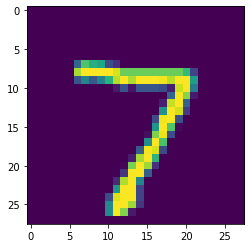

In [9]:
plt.figure()
plt.imshow(test_img.reshape(28,28))
plt.show()

### Save Model

In [10]:
subprocess.call("rm -rf mnist_model".split())

0

In [11]:
model.save('mnist_model')

INFO:tensorflow:Assets written to: mnist_model/assets


2022-04-26 14:59:19.988144: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


### Inspect saved model

In [12]:
subprocess.call("tree mnist_model".split())

mnist_model
├── assets
├── keras_metadata.pb
├── saved_model.pb
└── variables
    ├── variables.data-00000-of-00001
    └── variables.index

2 directories, 4 files


0

In [13]:
subprocess.call("saved_model_cli show --dir mnist_model --tag_set serve --signature_def serving_default".split())

The given SavedModel SignatureDef contains the following input(s):
  inputs['dense_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 784)
      name: serving_default_dense_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


0

### Load model

In [14]:
new_model = tf.keras.models.load_model('mnist_model')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [15]:
new_model.predict(test_images[:1])

array([[ -5.8419833, -10.383324 ,  -3.9259145,   1.4922768, -18.739622 ,
         -5.246328 , -19.053064 ,  12.755894 ,  -6.6638937,  -3.5348623]],
      dtype=float32)

## MLFlow PyFunc Model

### Save as MLFlow Model

In [16]:
import mlflow
import numpy as np
import subprocess
import tensorflow as tf

In [17]:
from mlflow.models.signature import infer_signature, ModelSignature
from mlflow.types.schema import Schema, TensorSpec

In [18]:
model = tf.keras.models.load_model("mnist_model")

#### Inferred signature (without input names)

In [19]:
signature = infer_signature(train_images, model.predict(train_images))
signature

inputs: 
  [Tensor('float32', (-1, 784))]
outputs: 
  [Tensor('float32', (-1, 10))]

In [20]:
subprocess.call("rm -rf mnist_mlflow_infer".split())
mlflow.tensorflow.save_model(tf_saved_model_dir="mnist_model", 
                             tf_meta_graph_tags=["serve"], 
                             tf_signature_def_key="serving_default",
                             signature=signature,
                             path="mnist_mlflow_infer")

2022/04/26 15:00:24 INFO mlflow.tensorflow: Validating the specified TensorFlow model by attempting to load it in a new TensorFlow graph...
2022/04/26 15:00:24 INFO mlflow.tensorflow: Validation succeeded!


#### Manual signature (with input names)

In [21]:
input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 784), "dense_input")])
output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 10), "dense_1")])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)
signature

inputs: 
  ['dense_input': Tensor('float32', (-1, 784))]
outputs: 
  ['dense_1': Tensor('float32', (-1, 10))]

In [22]:
subprocess.call("rm -rf mnist_mlflow_manual".split())
mlflow.tensorflow.save_model(tf_saved_model_dir="mnist_model", 
                             tf_meta_graph_tags=["serve"], 
                             tf_signature_def_key="serving_default",
                             signature=signature,
                             path="mnist_mlflow_manual")

2022/04/26 15:00:40 INFO mlflow.tensorflow: Validating the specified TensorFlow model by attempting to load it in a new TensorFlow graph...
2022/04/26 15:00:40 INFO mlflow.tensorflow: Validation succeeded!


### Load data as pandas.DataFrame of 784 floats

In [23]:
import numpy as np
import tensorflow as tf

# load dataset as numpy arrays
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [24]:
# flatten and normalize
train_images = train_images.astype(np.float32).reshape(-1, 784) / 255.0
test_images = test_images.astype(np.float32).reshape(-1, 784) / 255.0

In [25]:
import pandas as pd
test_pdf = pd.DataFrame(test_images) # .astype(float)
test_pdf

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Load data as pandas.DataFrame of 1 array of 784 floats

In [26]:
test_pdf1 = pd.DataFrame()
test_pdf1['dense_input'] = test_pdf.values.tolist()
test_pdf1

,dense_input
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...
9995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9996,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9997,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9998,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Infer using MLFlow PyFuncModel (inferred signature w/o input names)

In [27]:
import mlflow

In [28]:
# Note: Tensorflow "flavor" is defined in the MLModel file.
model_infer = mlflow.pyfunc.load_model("mnist_mlflow_infer")

In [29]:
print(model_infer.metadata)  # contents of MLModel file

flavors:
  python_function:
    env: conda.yaml
    loader_module: mlflow.tensorflow
    python_version: 3.9.10
  tensorflow:
    code: null
    meta_graph_tags:
    - serve
    saved_model_dir: tfmodel
    signature_def_key: serving_default
mlflow_version: 1.25.2.dev0
model_uuid: 04523f5ffcc447579d728dd1055a7aea
signature:
  inputs: '[{"type": "tensor", "tensor-spec": {"dtype": "float32", "shape": [-1, 784]}}]'
  outputs: '[{"type": "tensor", "tensor-spec": {"dtype": "float32", "shape": [-1,
    10]}}]'
utc_time_created: '2022-04-26 22:00:24.632879'



#### Infer using pandas.DataFrame (784 floats)

In [30]:
preds = model_infer.predict(test_pdf)
preds

TypeError: Only dict and DataFrame input types are supported, got: <class 'numpy.ndarray'>

In [31]:
type(test_pdf)

pandas.core.frame.DataFrame

#### Infer using pandas.DataFrame (array of 784 floats)

In [32]:
preds = model_infer.predict(test_pdf1)
preds

MlflowException: Shape of input (10000, 1) does not match expected shape (-1, 784).

#### Infer using dict

In [33]:
preds = model_infer.predict({"dense_input": test_images})

MlflowException: This model contains a tensor-based model signature with no input names, which suggests a numpy array input, but an input of type <class 'dict'> was found.

In [34]:
result = np.array(preds['dense_1'])
result.shape

NameError: name 'preds' is not defined

In [35]:
pd.DataFrame(preds['dense_1'])

NameError: name 'preds' is not defined

### Infer using MLFlow PyFuncModel (manual signature w/ input names)

In [37]:
# Note: Tensorflow "flavor" is defined in the MLModel file.
model_manual = mlflow.pyfunc.load_model("mnist_mlflow_manual")

In [38]:
print(model_manual.metadata)  # contents of MLModel file

flavors:
  python_function:
    env: conda.yaml
    loader_module: mlflow.tensorflow
    python_version: 3.9.10
  tensorflow:
    code: null
    meta_graph_tags:
    - serve
    saved_model_dir: tfmodel
    signature_def_key: serving_default
mlflow_version: 1.25.2.dev0
model_uuid: 91060fb595e34bf6978955da88a9d65e
signature:
  inputs: '[{"name": "dense_input", "type": "tensor", "tensor-spec": {"dtype": "float32",
    "shape": [-1, 784]}}]'
  outputs: '[{"name": "dense_1", "type": "tensor", "tensor-spec": {"dtype": "float32",
    "shape": [-1, 10]}}]'
utc_time_created: '2022-04-26 22:00:40.604597'



#### Infer using pandas.DataFrame

In [39]:
preds = model_manual.predict(test_pdf)
preds

MlflowException: Model is missing inputs ['dense_input']. Note that there were extra inputs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783]

#### Infer using pandas.DataFrame (array of 784 floats)

In [40]:
preds = model_manual.predict(test_pdf1)
preds

ValueError: setting an array element with a sequence.

#### Infer using dict

In [41]:
preds = model_manual.predict({"dense_input": test_images})

In [42]:
type(preds["dense_1"])

list

In [43]:
result = np.array(preds['dense_1'])
result.shape

(10000, 10)

In [44]:
pd.DataFrame(preds['dense_1'])

,0,1,2,3,4,5,6,7,8,9
0,-5.841984,-10.383325,-3.925916,1.492277,-18.739620,-5.246327,-19.053066,12.755895,-6.663895,-3.534862
1,-12.938910,0.710145,14.855471,-3.345494,-22.005724,-8.329589,-8.816965,-17.721798,-4.842685,-17.681454
2,-12.153997,6.292188,-4.426025,-6.096717,-4.840297,-7.875722,-5.291264,-2.292618,-0.789819,-9.625733
3,11.408954,-11.872353,-1.197140,-9.336616,-7.377591,-2.899515,-1.382964,-1.484285,-11.558947,-4.084096
4,-7.335523,-13.371641,-2.976302,-9.339242,10.150408,-4.679741,-4.731390,-2.726823,-5.452237,1.658148
...,...,...,...,...,...,...,...,...,...,...
9995,-12.560976,-1.898262,15.466688,0.245878,-30.197079,-5.165746,-14.938893,-1.622084,-3.197143,-13.300212
9996,-14.929013,-4.907559,-2.158203,10.304011,-20.291252,4.632127,-24.570541,-9.770651,-4.918324,4.263149
9997,-19.601368,-12.936716,-15.346132,-8.619569,14.286592,-10.463679,-13.707807,2.295944,-3.415435,4.011699
9998,-4.855701,-10.713496,-10.167618,-5.768750,-11.686323,14.755033,-5.110606,-8.004922,2.898157,-13.055156


## PySpark

In [45]:
import pandas as pd

# from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.sql.types import *

### Convert numpy array to Spark DataFrame (via Pandas DataFrame)

In [46]:
# numpy array to pandas DataFrame
test_pdf = pd.DataFrame(test_images) # .astype(float)
test_pdf.shape

(10000, 784)

In [67]:
test_pdf

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,data
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [48]:
%%time
# 784 columns of float
df = spark.createDataFrame(test_pdf).repartition(10)

CPU times: user 1min 9s, sys: 4.03 ms, total: 1min 9s
Wall time: 1min 12s


In [49]:
len(df.columns)

784

In [50]:
df.write.mode("overwrite").parquet("mnist_test_784")

22/04/26 15:43:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/04/26 15:43:38 WARN TaskSetManager: Stage 0 contains a task of very large size (4313 KiB). The maximum recommended task size is 1000 KiB.


In [51]:
%%time
# 1 column of array<float>
test_pdf['data'] = test_pdf.values.tolist()
pdf = test_pdf[['data']]
pdf.shape

CPU times: user 519 ms, sys: 0 ns, total: 519 ms
Wall time: 520 ms


(10000, 1)

In [52]:
schema = StructType([
StructField("data",ArrayType(FloatType()),True),
])

In [53]:
%%time
df1 = spark.createDataFrame(pdf, schema).repartition(10)

CPU times: user 3.3 s, sys: 0 ns, total: 3.3 s
Wall time: 3.37 s


In [54]:
df1.write.mode("overwrite").parquet("mnist_test")

22/04/26 15:43:48 WARN TaskSetManager: Stage 3 contains a task of very large size (4315 KiB). The maximum recommended task size is 1000 KiB.


In [55]:
len(df1.columns)

1

In [56]:
df1.schema

StructType(List(StructField(data,ArrayType(FloatType,true),true)))

## Inference using MLFlow pyfunc.spark_udf
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

### 784 columns of double

In [57]:
import mlflow

from pyspark.sql.functions import col, struct

In [58]:
df = spark.read.parquet("mnist_test_784")

In [59]:
columns = df.columns
len(columns)

784

#### Inferred schema

In [60]:
mnist = mlflow.pyfunc.spark_udf(spark, model_uri="mnist_mlflow_infer", result_type="array<float>")

2022/04/26 15:44:42 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


In [61]:
mnist.metadata.signature

inputs: 
  [Tensor('float32', (-1, 784))]
outputs: 
  [Tensor('float32', (-1, 10))]

In [62]:
%%time
preds = df.withColumn("preds", mnist(struct(*columns))).collect()

22/04/26 15:44:53 WARN TaskSetManager: Lost task 2.0 in stage 7.0 (TID 55) (192.168.86.223 executor 0): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 585, in _enforce_schema
    _enforce_tensor_schema(pfInput, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 509, in _enforce_tensor_schema
    new_pfInput = _enforce_tensor_spec(pfInput.to_numpy(), input_s

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 585, in _enforce_schema
    _enforce_tensor_schema(pfInput, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 509, in _enforce_tensor_schema
    new_pfInput = _enforce_tensor_spec(pfInput.to_numpy(), input_schema.inputs[0])
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 459, in _enforce_tensor_spec
    raise MlflowException(
mlflow.exceptions.MlflowException: dtype of input float64 does not match expected dtype float32


In [63]:
%%time
preds = df.withColumn("preds", mnist(*columns)).collect()

22/04/26 15:44:58 WARN TaskSetManager: Lost task 5.0 in stage 8.0 (TID 68) (192.168.86.223 executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 585, in _enforce_schema
    _enforce_tensor_schema(pfInput, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 509, in _enforce_tensor_schema
    new_pfInput = _enforce_tensor_spec(pfInput.to_numpy(), input_s

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 585, in _enforce_schema
    _enforce_tensor_schema(pfInput, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 509, in _enforce_tensor_schema
    new_pfInput = _enforce_tensor_spec(pfInput.to_numpy(), input_schema.inputs[0])
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 453, in _enforce_tensor_spec
    raise MlflowException(
mlflow.exceptions.MlflowException: Shape of input (1000, 1) does not match expected shape (-1, 784).


In [64]:
%%time
preds = df.withColumn("preds", mnist()).collect()

MlflowException: Cannot apply udf because no column names specified. The udf expects 1 columns with types: [Tensor('float32', (-1, 784))]. Input column names could not be inferred from the model signature (column names not found).

#### Manual schema

In [68]:
mnist = mlflow.pyfunc.spark_udf(spark, model_uri="mnist_mlflow_manual")

2022/04/26 15:45:51 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


In [69]:
mnist.metadata.signature

inputs: 
  ['dense_input': Tensor('float32', (-1, 784))]
outputs: 
  ['dense_1': Tensor('float32', (-1, 10))]

In [70]:
%%time
preds = df.withColumn("preds", mnist(struct(*columns))).collect()

22/04/26 15:45:58 WARN TaskSetManager: Lost task 0.0 in stage 9.0 (TID 73) (192.168.86.223 executor 0): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 569, in _enforce_schema
    raise MlflowException(
mlflow.exceptions.MlflowException: Model is missing inputs ['dense_input']. Note that there were extra inputs: ['190', '18', '263', '110', '695', '473', '563', '145', '38', '153', '335',

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 569, in _enforce_schema
    raise MlflowException(
mlflow.exceptions.MlflowException: Model is missing inputs ['dense_input']. Note that there were extra inputs: ['190', '18', '263', '110', '695', '473', '563', '145', '38', '153', '335', '730', '317', '472', '377', '118', '258', '343', '48', '242', '68', '84', '141', '569', '499', '342', '177', '430', '520', '399', '307', '346', '669', '780', '562', '598', '359', '61', '203', '600', '12', '693', '617', '417', '15', '220', '618', '348', '497', '689', '67', '73', '179', '358', '769', '56', '57', '95', '142', '613', '453', '180', '272', '278', '716', '737', '163', '334', '288', '489', '47', '238', '515', '687', '739', '427', '729', '590', '767', '101', '26', '773', '323', '244', '28', '98', '521', '487', '322', '23', '539', '533', '587', '333', '426', '626', '435', '757', '405', '510', '120', '586', '437', '516', '686', '419', '66', '418', '292', '775', '135', '367', '355', '291', '332', '215', '442', '483', '117', '762', '389', '228', '78', '421', '62', '455', '5', '467', '747', '246', '231', '36', '181', '443', '357', '407', '570', '387', '528', '639', '707', '440', '526', '500', '69', '676', '376', '127', '197', '493', '782', '144', '683', '386', '338', '44', '748', '315', '99', '492', '114', '666', '86', '654', '192', '771', '448', '347', '765', '629', '254', '606', '337', '506', '32', '219', '509', '711', '287', '325', '341', '529', '571', '614', '133', '249', '531', '778', '52', '297', '605', '354', '108', '217', '623', '267', '640', '111', '558', '296', '574', '20', '777', '34', '647', '532', '620', '312', '207', '411', '589', '420', '591', '22', '388', '514', '543', '735', '663', '779', '316', '410', '107', '194', '584', '736', '55', '431', '566', '758', '327', '363', '565', '564', '53', '652', '247', '286', '725', '54', '273', '280', '727', '49', '498', '157', '90', '31', '694', '139', '428', '646', '391', '88', '713', '294', '384', '151', '759', '311', '239', '656', '268', '572', '362', '221', '567', '170', '206', '241', '439', '630', '245', '409', '140', '593', '214', '761', '451', '282', '544', '211', '413', '191', '450', '167', '691', '328', '458', '306', '648', '352', '257', '709', '530', '277', '575', '703', '176', '209', '134', '469', '643', '172', '189', '631', '80', '196', '309', '202', '366', '662', '699', '269', '549', '754', '10', '522', '684', '303', '275', '148', '491', '508', '58', '429', '547', '555', '94', '768', '4', '85', '295', '697', '659', '199', '128', '721', '2', '650', '690', '750', '616', '624', '104', '74', '781', '554', '592', '597', '261', '452', '619', '422', '638', '524', '718', '171', '783', '210', '403', '159', '237', '380', '121', '700', '1', '205', '752', '222', '392', '119', '527', '204', '375', '447', '158', '603', '481', '279', '505', '657', '541', '746', '178', '76', '17', '365', '223', '198', '169', '256', '460', '579', '672', '50', '402', '512', '382', '446', '682', '374', '494', '281', '122', '685', '595', '634', '743', '742', '240', '414', '502', '398', '552', '162', '41', '43', '29', '166', '138', '368', '360', '416', '218', '717', '568', '763', '182', '248', '594', '330', '63', '87', '252', '147', '658', '692', '216', '518', '635', '276', '536', '30', '760', '588', '232', '486', '728', '243', '125', '400', '628', '16', '103', '661', '200', '456', '496', '175', '556', '236', '637', '71', '174', '187', '719', '578', '313', '6', '93', '92', '542', '424', '83', '136', '265', '59', '89', '596', '155', '601', '154', '480', '667', '369', '226', '109', '423', '772', '612', '102', '185', '290', '604', '756', '385', '645', '186', '253', '344', '126', '143', '149', '670', '678', '213', '432', '130', '677', '305', '401', '370', '412', '396', '770', '156', '165', '339', '393', '534', '234', '641', '525', '559', '488', '19', '208', '466', '513', '314', '610', '212', '274', '81', '463', '173', '766', '632', '644', '733', '548', '582', '704', '523', '723', '436', '749', '113', '340', '160', '131', '731', '259', '195', '681', '45', '607', '96', '371', '706', '664', '193', '112', '679', '519', '705', '75', '535', '708', '364', '504', '621', '356', '633', '734', '97', '495', '65', '702', '573', '540', '581', '698', '283', '298', '14', '289', '406', '655', '225', '353', '233', '8', '37', '46', '301', '302', '462', '649', '106', '361', '627', '72', '372', '404', '438', '720', '77', '152', '308', '310', '184', '560', '726', '394', '517', '714', '660', '116', '13', '82', '0', '468', '485', '722', '576', '501', '751', '764', '580', '235', '444', '299', '611', '39', '449', '379', '395', '115', '100', '318', '425', '464', '553', '201', '300', '381', '550', '545', '3', '255', '285', '250', '351', '551', '561', '609', '490', '696', '688', '651', '161', '680', '701', '224', '712', '7', '329', '710', '753', '668', '459', '227', '674', '715', '345', '433', '441', '129', '9', '350', '774', '164', '229', '42', '776', '188', '454', '740', '732', '326', '577', '538', '25', '378', '675', '408', '461', '478', '636', '653', '21', '744', '40', '132', '266', '484', '673', '251', '264', '183', '27', '373', '260', '475', '91', '320', '123', '270', '474', '602', '622', '642', '79', '476', '583', '755', '324', '11', '557', '321', '319', '477', '60', '51', '390', '146', '537', '137', '397', '445', '724', '24', '470', '615', '665', '511', '230', '124', '608', '271', '331', '482', '349', '262', '741', '457', '671', '64', '479', '70', '507', '415', '434', '599', '465', '383', '503', '585', '738', '168', '35', '293', '105', '745', '304', '546', '625', '471', '284', '150', '336', '33']


In [71]:
%%time
preds = df.withColumn("preds", mnist(*columns)).collect()

22/04/26 15:45:58 WARN TaskSetManager: Lost task 1.0 in stage 9.0 (TID 74) (192.168.86.223 executor 1): TaskKilled (Stage cancelled)
22/04/26 15:45:58 WARN TaskSetManager: Lost task 5.0 in stage 9.0 (TID 78) (192.168.86.223 executor 1): TaskKilled (Stage cancelled)
22/04/26 15:45:58 WARN TaskSetManager: Lost task 3.0 in stage 9.0 (TID 76) (192.168.86.223 executor 1): TaskKilled (Stage cancelled)
22/04/26 15:45:58 WARN TaskSetManager: Lost task 9.0 in stage 9.0 (TID 82) (192.168.86.223 executor 1): TaskKilled (Stage cancelled)
22/04/26 15:45:58 WARN TaskSetManager: Lost task 7.0 in stage 9.0 (TID 80) (192.168.86.223 executor 1): TaskKilled (Stage cancelled)
22/04/26 15:46:03 WARN TaskSetManager: Lost task 8.0 in stage 10.0 (TID 91) (192.168.86.223 executor 0): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 585, in _enforce_schema
    _enforce_tensor_schema(pfInput, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 498, in _enforce_tensor_schema
    new_pfInput[col_name] = _enforce_tensor_spec(
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 444, in _enforce_tensor_spec
    raise MlflowException(
mlflow.exceptions.MlflowException: Shape of input (999,) does not match expected shape (-1, 784).


In [72]:
%%time
preds = df.withColumn("preds", mnist()).collect()

AnalysisException: cannot resolve 'dense_input' given input columns: [0, 1, 10, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 11, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 12, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 13, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 14, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 15, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 16, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 17, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 19, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 2, 20, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 23, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 24, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 25, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 26, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 27, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 28, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 29, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 3, 30, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 31, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 32, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 33, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 34, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 35, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 36, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 37, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 38, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 39, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 4, 40, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 41, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 42, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 43, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 44, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 45, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 46, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 47, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 48, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 49, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 5, 50, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 51, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 52, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 53, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 54, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 55, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 56, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 57, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 58, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 59, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 6, 60, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 61, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 62, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 63, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 64, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 65, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 66, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 67, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 68, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 69, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 7, 70, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 71, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 72, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 73, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 74, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 75, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 76, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 77, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 78, 780, 781, 782, 783, 79, 8, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99];
'Project [0#2355, 1#2356, 2#2357, 3#2358, 4#2359, 5#2360, 6#2361, 7#2362, 8#2363, 9#2364, 10#2365, 11#2366, 12#2367, 13#2368, 14#2369, 15#2370, 16#2371, 17#2372, 18#2373, 19#2374, 20#2375, 21#2376, 22#2377, 23#2378, ... 761 more fields]
+- Relation [0#2355,1#2356,2#2357,3#2358,4#2359,5#2360,6#2361,7#2362,8#2363,9#2364,10#2365,11#2366,12#2367,13#2368,14#2369,15#2370,16#2371,17#2372,18#2373,19#2374,20#2375,21#2376,22#2377,23#2378,... 760 more fields] parquet


### 1 column of 784 float

In [74]:
import mlflow
from pyspark.sql.functions import struct

In [75]:
df1 = spark.read.parquet("mnist_test").withColumnRenamed("data", "dense_input")

In [76]:
columns = df1.columns
columns

['dense_input']

In [77]:
df1.schema

StructType(List(StructField(dense_input,ArrayType(FloatType,true),true)))

#### Inferred schema

In [78]:
mnist_infer = mlflow.pyfunc.spark_udf(spark, model_uri="mnist_mlflow_infer", result_type="array<float>")

2022/04/26 15:46:47 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


In [79]:
mnist_infer.metadata.signature

inputs: 
  [Tensor('float32', (-1, 784))]
outputs: 
  [Tensor('float32', (-1, 10))]

In [80]:
%%time
preds = df1.withColumn("preds", mnist_infer(struct(*columns))).collect()

22/04/26 15:46:51 WARN TaskSetManager: Lost task 4.0 in stage 12.0 (TID 98) (192.168.86.223 executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 585, in _enforce_schema
    _enforce_tensor_schema(pfInput, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 509, in _enforce_tensor_schema
    new_pfInput = _enforce_tensor_spec(pfInput.to_numpy(), input_

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 585, in _enforce_schema
    _enforce_tensor_schema(pfInput, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 509, in _enforce_tensor_schema
    new_pfInput = _enforce_tensor_spec(pfInput.to_numpy(), input_schema.inputs[0])
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 453, in _enforce_tensor_spec
    raise MlflowException(
mlflow.exceptions.MlflowException: Shape of input (1000, 1) does not match expected shape (-1, 784).


In [81]:
%%time
preds = df1.withColumn("preds", mnist_infer(*columns)).collect()

22/04/26 15:46:51 WARN TaskSetManager: Lost task 0.0 in stage 12.0 (TID 94) (192.168.86.223 executor 1): TaskKilled (Stage cancelled)
22/04/26 15:46:51 WARN TaskSetManager: Lost task 1.0 in stage 12.0 (TID 95) (192.168.86.223 executor 0): TaskKilled (Stage cancelled)
22/04/26 15:46:51 WARN TaskSetManager: Lost task 6.0 in stage 12.0 (TID 100) (192.168.86.223 executor 1): TaskKilled (Stage cancelled)
22/04/26 15:46:51 WARN TaskSetManager: Lost task 8.0 in stage 12.0 (TID 102) (192.168.86.223 executor 1): TaskKilled (Stage cancelled)
22/04/26 15:46:51 WARN TaskSetManager: Lost task 7.0 in stage 12.0 (TID 101) (192.168.86.223 executor 0): TaskKilled (Stage cancelled)
22/04/26 15:46:51 WARN TaskSetManager: Lost task 9.0 in stage 12.0 (TID 103) (192.168.86.223 executor 0): TaskKilled (Stage cancelled)
22/04/26 15:46:51 WARN TaskSetManager: Lost task 5.0 in stage 12.0 (TID 99) (192.168.86.223 executor 0): TaskKilled (Stage cancelled)
22/04/26 15:46:51 WARN TaskSetManager: Lost task 2.0 in st

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 585, in _enforce_schema
    _enforce_tensor_schema(pfInput, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 509, in _enforce_tensor_schema
    new_pfInput = _enforce_tensor_spec(pfInput.to_numpy(), input_schema.inputs[0])
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 453, in _enforce_tensor_spec
    raise MlflowException(
mlflow.exceptions.MlflowException: Shape of input (999, 1) does not match expected shape (-1, 784).


In [82]:
%%time
preds = df1.withColumn("preds", mnist_infer()).collect()

MlflowException: Cannot apply udf because no column names specified. The udf expects 1 columns with types: [Tensor('float32', (-1, 784))]. Input column names could not be inferred from the model signature (column names not found).

#### Manual schema 

In [83]:
mnist = mlflow.pyfunc.spark_udf(spark, model_uri="mnist_mlflow_manual", result_type="array<float>")

2022/04/26 15:46:55 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


In [84]:
mnist.metadata.signature

inputs: 
  ['dense_input': Tensor('float32', (-1, 784))]
outputs: 
  ['dense_1': Tensor('float32', (-1, 10))]

In [85]:
%%time
preds = df1.withColumn("preds", mnist(struct(*columns))).collect()

22/04/26 15:46:58 WARN TaskSetManager: Lost task 3.0 in stage 14.0 (TID 117) (192.168.86.223 executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 585, in _enforce_schema
    _enforce_tensor_schema(pfInput, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 499, in _enforce_tensor_schema
    np.array(pfInput[col_name], dtype=tensor_spec.type), tensor_

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 585, in _enforce_schema
    _enforce_tensor_schema(pfInput, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 499, in _enforce_tensor_schema
    np.array(pfInput[col_name], dtype=tensor_spec.type), tensor_spec
  File "/home/leey/.pyenv/versions/sparkext_mlflow/lib/python3.9/site-packages/pandas/core/series.py", line 872, in __array__
    return np.asarray(self._values, dtype)
ValueError: setting an array element with a sequence.


In [86]:
%%time
preds = df1.withColumn("preds", mnist(*columns)).collect()

22/04/26 15:46:58 WARN TaskSetManager: Lost task 7.0 in stage 14.0 (TID 121) (192.168.86.223 executor 1): TaskKilled (Stage cancelled)
22/04/26 15:47:01 WARN TaskSetManager: Lost task 3.0 in stage 15.0 (TID 127) (192.168.86.223 executor 0): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 585, in _enforce_schema
    _enforce_tensor_schema(pfInput, input_schema)
  File "/home/leey/devpub/

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 585, in _enforce_schema
    _enforce_tensor_schema(pfInput, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 499, in _enforce_tensor_schema
    np.array(pfInput[col_name], dtype=tensor_spec.type), tensor_spec
  File "/home/leey/.pyenv/versions/sparkext_mlflow/lib/python3.9/site-packages/pandas/core/series.py", line 872, in __array__
    return np.asarray(self._values, dtype)
ValueError: setting an array element with a sequence.


In [87]:
%%time
preds = df1.withColumn("preds", mnist()).collect()

22/04/26 15:47:01 WARN TaskSetManager: Lost task 4.0 in stage 15.0 (TID 128) (192.168.86.223 executor 1): TaskKilled (Stage cancelled)
22/04/26 15:47:04 WARN TaskSetManager: Lost task 0.0 in stage 16.0 (TID 134) (192.168.86.223 executor 0): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 585, in _enforce_schema
    _enforce_tensor_schema(pfInput, input_schema)
  File "/home/leey/devpub/

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1273, in udf
    os.kill(scoring_server_proc.pid, signal.SIGTERM)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1115, in _predict_row_batch
    result = predict_fn(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 1255, in batch_predict_fn
    return loaded_model.predict(pdf)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 630, in predict
    data = _enforce_schema(data, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 585, in _enforce_schema
    _enforce_tensor_schema(pfInput, input_schema)
  File "/home/leey/devpub/mlflow/mlflow/pyfunc/__init__.py", line 499, in _enforce_tensor_schema
    np.array(pfInput[col_name], dtype=tensor_spec.type), tensor_spec
  File "/home/leey/.pyenv/versions/sparkext_mlflow/lib/python3.9/site-packages/pandas/core/series.py", line 872, in __array__
    return np.asarray(self._values, dtype)
ValueError: setting an array element with a sequence.


22/04/26 15:47:31 WARN Dispatcher: Message RemoteProcessDisconnected(192.168.86.223:41542) dropped. Could not find BlockManagerMasterHeartbeat.
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/leey/devpub/spark/python/lib/py4j-0.10.9.2-src.zip/py4j/clientserver.py", line 480, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/leey/devpub/spark/python/lib/py4j-0.10.9.2-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/leey/devpub/spark/python/lib/py4j-0.10.9.2-src.zip/py4j/clientserver.py", line 503, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


### Check Predictions

In [ ]:
preds[0].preds

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
img = test_pdf.values[0]

In [ ]:
img = np.array(preds[0].dense_input)

In [ ]:
plt.figure()
plt.imshow(img.reshape(28,28))
plt.show()